In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import f1_score
from scipy import stats
import statsmodels.api as sm

from diffprivlib.models import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression as LR

In [25]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

# Normal dataset
df = pd.read_csv('CSVFiles/small10000DomainDataBertweetEmbedded.csv')

df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

FileNotFoundError: [Errno 2] No such file or directory: 'CSVFiles/small10000DomainDataBertweetEmbedded.csv'

In [3]:
# Updating values for training_data, since no need for val set
training_data = df[(df['split'] == 'train') | (df['split'] == 'val')]

# Getting test_data
test_data = df[df['split'] == 'test']

In [4]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  4220.0
None-toxic samples training data:  4220.0


Toxic samples test data:  710.0
None-toxic samples test data:  710.0


male: 2031.0
female: 1849.0
LGBTQ: 1372.0
christian: 1310.0
muslim: 1421.0
other_religion: 40.0
black: 1511.0
white: 2184.0


In [5]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [6]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

In [7]:
#epsilons = np.linspace(0.0001, 100, 1000)
#epsilons = np.linspace(0.0001, 100, 10)

epsilons = np.linspace(0.1, 40, 400)

allModelLsts = []
for i in range(15):
    modelLst = []
    for eps in epsilons:
        #clf = LogisticRegression(epsilon=eps, max_iter=30000, data_norm=4.979391198106228)
        clf = LogisticRegression(epsilon=eps, max_iter=30000, data_norm=5.069251772214575)
        clf.fit(X_train, Y_train)
        modelLst.append(clf)
    allModelLsts.append(modelLst)

In [8]:
#100 datapunkter

#80 ikke sort
#40 toxic og 40 ikke toxic

#20 sort
#5 toxic og 15 ikke toxic

#20 hvide 
#8 toxic og 12 ikke toxic

#Gætter alt rigigt p-rule 100%:
((8/100)/(20/100))/((40/100)/(80/100))

0.7999999999999999

In [9]:
def DemoAndF1AndAcc(model, df):
    f1_scores = []
    accuracies = []
    demographics = []
    
    for col in df.columns[3:]:
        tempdf = df[(df[col] == 1)]      
        
        tempX = np.array(tempdf['comment_text'].values.tolist())
        tempY = np.array(tempdf['toxicity'].values.tolist())
        
        predictions = model.predict(tempX)
        
        f1_scores.append(f1_score(tempY, predictions, zero_division=1))
        accuracies.append(CheckAccuracy(tempY, predictions))
        demographics.append(col)
            
    return np.array(demographics), np.array(f1_scores), np.array(accuracies)

def pRule(model, df):
    pRules = []
    
    for col in df.columns[3:]:
        
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        tempXz1 = np.array(tempdfz1['comment_text'].values.tolist())
        tempYz1 = np.array(tempdfz1['toxicity'].values.tolist())
        
        tempXz0 = np.array(tempdfz0['comment_text'].values.tolist())
        tempYz0 = np.array(tempdfz0['toxicity'].values.tolist())
        
        predictionsz1 = model.predict(tempXz1)
        predictionsz0 = model.predict(tempXz0)
        
        with np.errstate(divide='ignore'):
            
                       
            z1Ut1 = np.sum(predictionsz1)/len(df)
            pz1 = len(predictionsz1)/len(df)
            
            z0Ut1 = np.sum(predictionsz0)/len(df)
            pz0 = len(predictionsz0)/len(df)

            pscore0 = (z1Ut1/pz1) / (z0Ut1/pz0)
            pscore1 = (z0Ut1/pz0) / (z1Ut1/pz1)
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def pRuleOwn(model, df):
    pRules = []
    
    for col in df.columns[3:]:
        tempdfz1 = df[(df[col] == 1)]      
        tempdfz0 = df[(df[col] == 0)]
        
        tempXz1 = np.array(tempdfz1['comment_text'].values.tolist())
        tempYz1 = np.array(tempdfz1['toxicity'].values.tolist())
        
        tempXz0 = np.array(tempdfz0['comment_text'].values.tolist())
        tempYz0 = np.array(tempdfz0['toxicity'].values.tolist())
        
        predictionsz1 = model.predict(tempXz1)
        predictionsz0 = model.predict(tempXz0)
        
        with np.errstate(divide='ignore'):
            pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
            pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
        
        if np.isnan(pscore0) or np.isnan(pscore1):
            finalpscore = 0
        else:
            finalpscore = min(pscore0, pscore1)
        
        pRules.append(finalpscore)
    return pRules

def MinMaxFairness(scores):
    return np.max(scores)-np.min(scores)

def VarianceFairness(scores):
    return np.var(scores)

In [10]:
def IndividualFairness(model, df):
    tempdf = df[(df[col] == 1)]
    
    X = np.array(tempdf['comment_text'].values.tolist())
    
    distSamples = []
    distOutputs = []
    
    predict_proba = clf.predict_proba(X)[:,0]    
    
    for i in range(len(X)):
        for j in range(len(X)):
            tempDistSample = np.linalg.norm(X[i]-X[j])
            distSamples.append(tempDistSample)
            
            tempDistOutput = np.linalg.norm(predict_proba[i]-predict_proba[j])
            distOutputs.append(tempDistOutput)
    
    distSamples = np.array(distSamples)/np.max(distSamples)
    distOutputs = np.array(distOutputs)/np.max(distOutputs)
    
    unfairScore = np.sum(distOutputs > distSamples)
    
    return unfairScore/len(distOutputs)


In [11]:
#individualFairnessArr = []

allvarF1 = []
allvarAcc = []
allminMaxF1 = []
allminMaxAcc = []

allpRuleOwnMeanArr = []
allpRuleOwnMinArr = []
allpRuleMeanArr = []
allpRuleMinArr = []

allaccuracy = []

for modelLst in allModelLsts:
    varF1 = []
    varAcc = []
    minMaxF1 = []
    minMaxAcc = []
    pRuleOwnMeanArr = []
    pRuleOwnMinArr = []
    pRuleMeanArr = []
    pRuleMinArr = []
    accuracy = []
    for model in modelLst:
        
        demographics, f1_scores, accuracies = DemoAndF1AndAcc(model, test_data)
        
        own = pRuleOwn(model, test_data)       
        pRuleOwnMinArr.append(np.min(own))
        pRuleOwnMeanArr.append(np.mean(own))
        
        official = pRule(model, test_data)
        pRuleMinArr.append(np.min(official))
        pRuleMeanArr.append(np.mean(official))
        
        #F1 Variance
        varF1.append(VarianceFairness(f1_scores))
        varAcc.append(VarianceFairness(accuracies))
        
        #F1 Min Max
        minMaxF1.append(MinMaxFairness(f1_scores))
        minMaxAcc.append(MinMaxFairness(accuracies))
        
        accuracy.append(model.score(X_test, Y_test))
        
    allvarF1.append(np.array(varF1))
    allvarAcc.append(np.array(varAcc))
    allminMaxF1.append(np.array(minMaxF1))
    allminMaxAcc.append(np.array(minMaxAcc))
    
    allpRuleOwnMeanArr.append(np.array(pRuleOwnMeanArr))
    allpRuleOwnMinArr.append(np.array(pRuleOwnMinArr))
    allpRuleMeanArr.append(np.array(pRuleMeanArr))
    allpRuleMinArr.append(np.array(pRuleMinArr))
    
    allaccuracy.append(np.array(accuracy))
    
allvarF1 = np.array(allvarF1)
allvarAcc = np.array(allvarAcc)
allminMaxF1 = np.array(allminMaxF1)
allminMaxAcc = np.array(allminMaxAcc)
allaccuracy = np.array(allaccuracy)

allpRuleOwnMeanArr = np.array(allpRuleOwnMeanArr)
allpRuleOwnMinArr = np.array(allpRuleOwnMinArr)
allpRuleMeanArr = np.array(allpRuleMeanArr)
allpRuleMinArr = np.array(allpRuleMinArr)

<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value 

<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value encountered in double_scalars
  pscore1 = (np.sum(predictionsz0)/np.sum(tempYz0))/(np.sum(predictionsz1)/np.sum(tempYz1))
<ipython-input-9-fab0c1fb549e>:75: RuntimeWarning: invalid value encountered in double_scalars
  pscore0 = (np.sum(predictionsz1)/np.sum(tempYz1))/(np.sum(predictionsz0)/np.sum(tempYz0))
<ipython-input-9-fab0c1fb549e>:76: RuntimeWarning: invalid value 

In [12]:
allvarF1 = allvarF1.mean(axis=0)
allvarAcc = allvarAcc.mean(axis=0)
allminMaxF1 = allminMaxF1.mean(axis=0)
allminMaxAcc = allminMaxAcc.mean(axis=0)
allaccuracy = allaccuracy.mean(axis=0)
allpRuleOwnMeanArr = allpRuleOwnMeanArr.mean(axis=0)
allpRuleOwnMinArr = allpRuleOwnMinArr.mean(axis=0)
allpRuleMeanArr = allpRuleMeanArr.mean(axis=0)
allpRuleMinArr = allpRuleMinArr.mean(axis=0)

In [23]:
LogisticRegressionModel = LR(max_iter=30000)
LogisticRegressionModel.fit(X_train, Y_train)
demographics, f1_scores, accuracies = DemoAndF1AndAcc(LogisticRegressionModel, test_data)

LogisticRegressionModelScore = LogisticRegressionModel.score(X_test, Y_test)

own = pRuleOwn(LogisticRegressionModel, test_data)     
pRuleOwnMin = np.min(own)
pRuleOwnMean = np.mean(own)
        
official = pRule(LogisticRegressionModel, test_data)
pRuleMin = np.min(official)
pRuleMean = np.mean(official)

NameError: name 'X_train' is not defined

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     336.2
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           7.09e-55
Time:                        16:21:10   Log-Likelihood:                 1114.6
No. Observations:                 400   AIC:                            -2225.
Df Residuals:                     398   BIC:                            -2217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8568      0.001    572.012      0.0

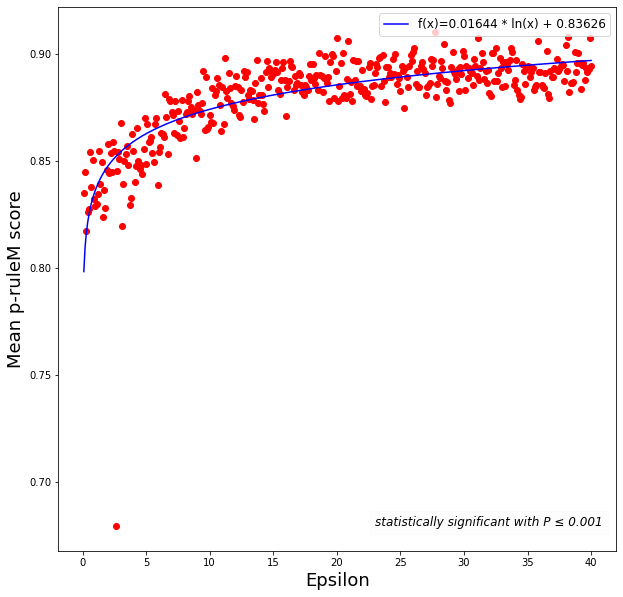

In [83]:
# PLOT OWN P-RULE MEAN

m, b = np.polyfit(np.log(epsilons), allpRuleOwnMeanArr, 1)

X2 = sm.add_constant(epsilons)
est = sm.OLS(allpRuleOwnMeanArr, X2)
est2 = est.fit()
print(est2.summary())


print(stats.pearsonr(np.log(epsilons), allpRuleOwnMeanArr))

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMeanArr, color='r')
#plt.scatter(epsilons, epsValues)
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-ruleM score", fontsize=18)
plt.text(23, min(allpRuleOwnMeanArr),'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OwnMean400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     327.5
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           7.74e-54
Time:                        16:21:15   Log-Likelihood:                 822.81
No. Observations:                 400   AIC:                            -1642.
Df Residuals:                     398   BIC:                            -1634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6379      0.005    139.248      0.0

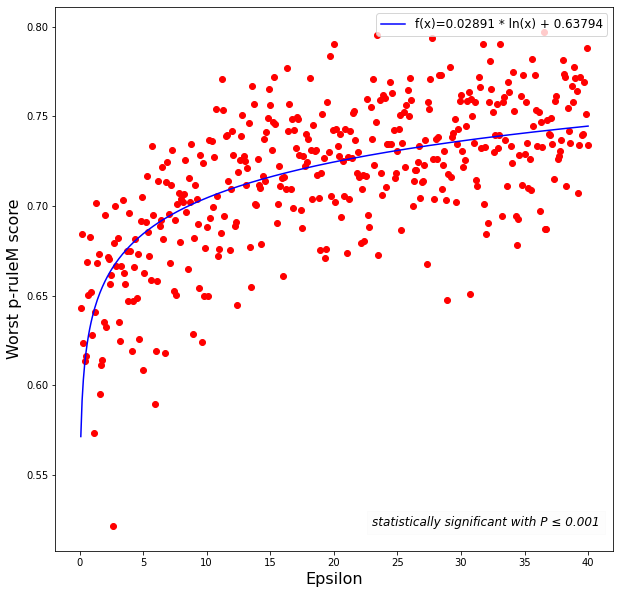

In [84]:
# PLOT OWN P-RULE MIN

m, b = np.polyfit(np.log(epsilons), allpRuleOwnMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleOwnMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleOwnMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
#plt.plot(epsilons, 0*epsilons + pRuleOwnMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=16)
plt.ylabel("Worst p-ruleM score", fontsize=16)
plt.text(23, min(allpRuleOwnMinArr),'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OwnMin400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     104.8
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           5.49e-22
Time:                        16:19:52   Log-Likelihood:                 812.46
No. Observations:                 400   AIC:                            -1621.
Df Residuals:                     398   BIC:                            -1613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6743      0.005    143.423      0.0

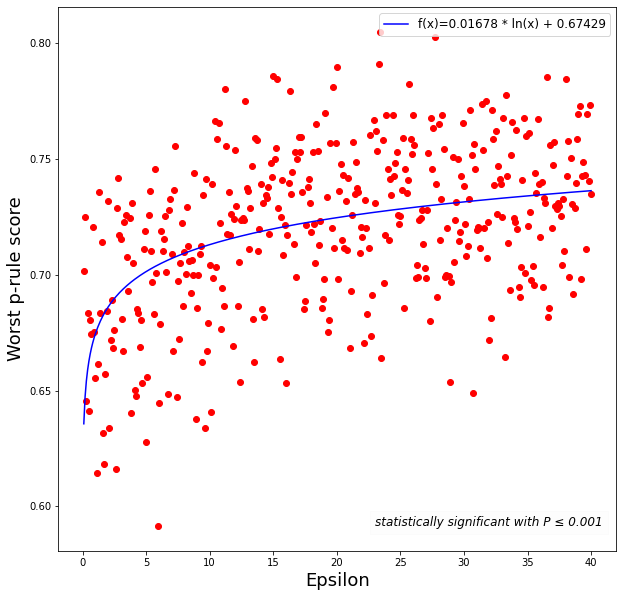

In [82]:
# PLOT OFFICIAL P-RULE MIN

m, b = np.polyfit(np.log(epsilons), allpRuleMinArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMinArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMinArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))

#plt.plot(epsilons, 0*epsilons + pRuleMin)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Worst p-rule score", fontsize=18)

plt.text(23, min(allpRuleMinArr),'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})

plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OfficialMin400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     277.2
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           1.31e-47
Time:                        16:19:05   Log-Likelihood:                 1189.1
No. Observations:                 400   AIC:                            -2374.
Df Residuals:                     398   BIC:                            -2366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8538      0.002    465.624      0.0

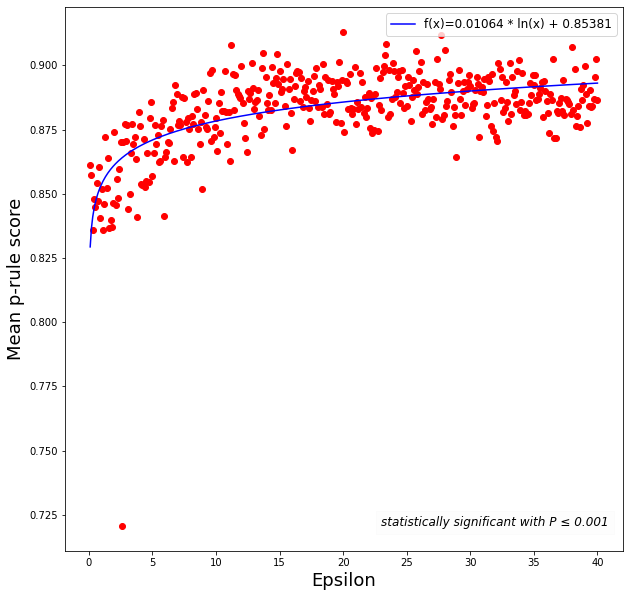

In [81]:
# PLOT OFFICIAL P-RULE Mean

m, b = np.polyfit(np.log(epsilons), allpRuleMeanArr, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allpRuleMeanArr, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allpRuleMeanArr, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.text(23, min(allpRuleMeanArr),'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
#plt.plot(epsilons, 0*epsilons + pRuleMean)
#plt.title("", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Mean p-rule score", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15OfficialMean400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     56.75
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.36e-13
Time:                        16:15:39   Log-Likelihood:                 2258.6
No. Observations:                 400   AIC:                            -4513.
Df Residuals:                     398   BIC:                            -4505.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.000     32.839      0.0

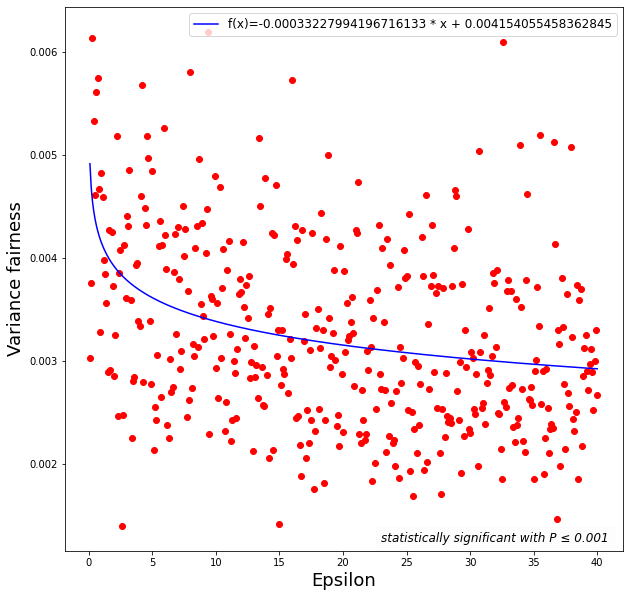

In [80]:
m, b = np.polyfit(np.log(epsilons), allvarF1, 1)

X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allvarF1, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+str(m)+' * x + '+str(b))
#plt.title("Fairness", fontsize=18)
plt.xlabel("Epsilon", fontsize=18)
plt.text(23, 0.00125,'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})

plt.ylabel("Variance fairness", fontsize=18)
plt.legend(loc="upper right", fontsize=12)
plt.savefig('15minmaxf1400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     56.75
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.36e-13
Time:                        16:12:23   Log-Likelihood:                 2258.6
No. Observations:                 400   AIC:                            -4513.
Df Residuals:                     398   BIC:                            -4505.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.000     32.839      0.0

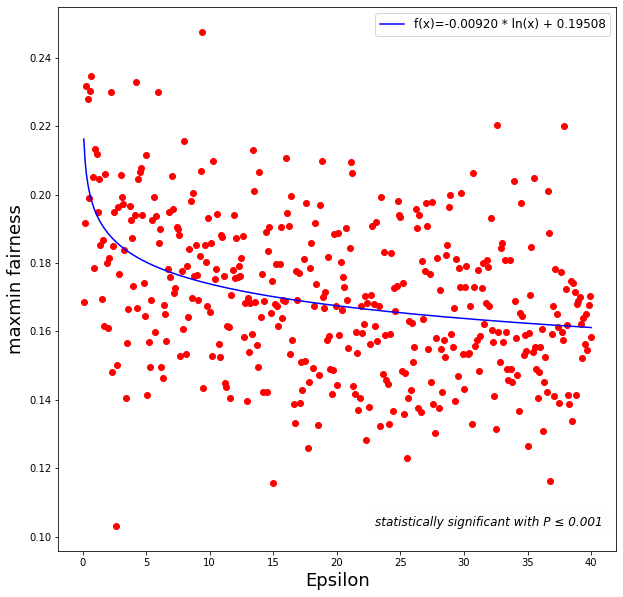

In [67]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allvarF1, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allminMaxF1, 1)
plt.figure(figsize=(10,10))
plt.scatter(epsilons, allminMaxF1, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("maxmin fairness", fontsize=18)

plt.text(23, min(allminMaxF1),'statistically significant with P ≤ 0.001', fontsize=12,  color='black',style='italic', bbox={'facecolor': 'grey', 'alpha': 0.01, 'pad': 5})
plt.legend(loc="upper right", fontsize=12)

plt.savefig('15varf1400models0to40eps.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     4605.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):          7.17e-221
Time:                        14:50:52   Log-Likelihood:                 1248.7
No. Observations:                 400   AIC:                            -2493.
Df Residuals:                     398   BIC:                            -2485.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5044      0.002    319.288      0.0

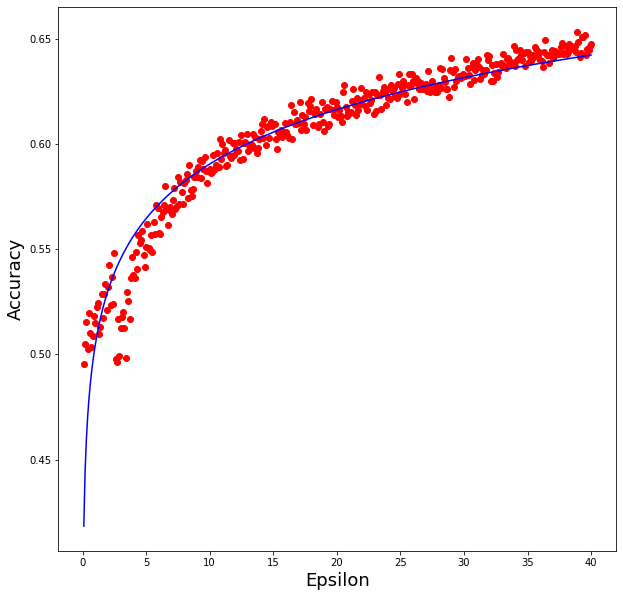

In [32]:
X2 = sm.add_constant(np.log(epsilons))
est = sm.OLS(allaccuracy, X2)
est2 = est.fit()
print(est2.summary())

m, b = np.polyfit(np.log(epsilons), allaccuracy, 1)

plt.figure(figsize=(10,10))
plt.scatter(epsilons, allaccuracy, color='r')
plt.plot(epsilons, m*np.log(epsilons) + b, color='b', label='f(x)='+"{:.5f}".format(m)+' * ln(x) + '+ "{:.5f}".format(b))
plt.xlabel("Epsilon", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.savefig('15accuracy400models0to40eps.png', bbox_inches='tight')
plt.show()

In [59]:
with open('test.npy', 'wb') as f:
    np.save(f, epsilons)
    np.save(f, allvarF1)
    np.save(f, allvarAcc)
    np.save(f, allminMaxF1)
    np.save(f, allminMaxAcc)
    np.save(f, allaccuracy)
    np.save(f, allpRuleOwnMeanArr)
    np.save(f, allpRuleOwnMinArr)
    np.save(f, allpRuleMeanArr)
    np.save(f, allpRuleMinArr)

In [3]:
with open('test.npy', 'rb') as f:
    epsilons = np.load(f)
    allvarF1 = np.load(f)
    allvarAcc = np.load(f)
    allminMaxF1 = np.load(f)
    allminMaxAcc = np.load(f)
    allaccuracy = np.load(f)
    allpRuleOwnMeanArr = np.load(f)
    allpRuleOwnMinArr = np.load(f)
    allpRuleMeanArr = np.load(f)
    allpRuleMinArr = np.load(f)